In [2]:
!pip install transformers
!pip install torch
!pip install scikit-learn
!pip install datasets torchmetrics gradio kaggle typing-extensions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.1/305.1 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 

In [4]:
from google.colab import drive
import shutil
import os
drive.mount('/content/drive', force_remount=True)

source_folder_path = '/content/drive/My Drive/fac/master/bigData'

destination_folder_path = '/content/bigData'
shutil.copytree(source_folder_path, destination_folder_path)
directory_path = '/content/bigData/big_data_project'

os.chdir(directory_path)

Mounted at /content/drive


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from tqdm import tqdm
import sys
sys.path.append('/content/drive/My Drive/fac/master/bigData/big_data_project')

from data_pipeline import get_dataloaders, text_preprocess, isot_clean

checkpoint_path = '../../drive/My Drive/fac/master/bigData/trained_model/'
trainset_path = 'drive/My Drive/fac/master/bigData/big_data_project/train.csv'
testset_path = 'drive/My Drive/fac/master/bigData/big_data_project/test.csv'

(train_loader, val_loader, test_loader), (tokenizer, vocab) = get_dataloaders(dataset_id="isot", model="bert")

def inference(model, input_str, max_len=512, isot=False, device="cpu", processor=None):
    if isot:
        input_str = isot_clean(input_str)
    # tokenizer, vocab = processor
    preprocessed = text_preprocess(input_str)
    token_ids = vocab(tokenizer(preprocessed))
    if not token_ids:
        return np.array([0.5, 0.5])
    input_ids = torch.tensor(token_ids[:max_len]).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        prediction = model(input_ids).squeeze().detach().cpu().item()

    return np.array([1 - prediction, prediction])

###################################################################################################

class BERTModel(nn.Module):
    def __init__(self, num_labels):
        super(BERTModel, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

    def forward(self, input_ids, attention_mask):
        return self.bert(input_ids=input_ids, attention_mask=attention_mask).logits

model = BERTModel(num_labels=2)  # Assuming binary classification, adjust num_labels accordingly

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion.to(device)
best_val_loss = float('inf')
patience = 2
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_labels, train_preds = [], []
    train_loss = 0.0

    for batch in train_loader:
        optimizer.zero_grad()

        inputs = batch[0]
        labels = batch[1].to(device)

        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        predictions = torch.argmax(logits, dim=1)
        train_labels.extend(labels.cpu().numpy())
        train_preds.extend(predictions.cpu().numpy())

        train_loss += loss.item()

    # Average training loss
    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_labels, val_preds = [], []
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch[0]
            labels = batch[1].to(device)

            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(logits, labels)
            val_loss += loss.item()

            predictions = torch.argmax(logits, dim=1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predictions.cpu().numpy())

    # Average validation loss
    val_loss /= len(val_loader)

    train_accuracy = accuracy_score(train_labels, train_preds)
    val_accuracy = accuracy_score(val_labels, val_preds)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint_full_path = checkpoint_path + "bert_isot.tar"
        model_config = {
            "num_labels" : 2
        }
        torch.save(
            {
                "epoch": epoch+1,
                "model_state_dict": model.state_dict(),
                "model_config": model_config,
                "optimizer_state_dict": optimizer.state_dict()
            },
            checkpoint_full_path
        )

        patience_counter = 0
    else:
        patience_counter += 1

    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, '
          f'Patience Counter: {patience_counter}')

    # Check for early stopping
    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch + 1} due to no improvement in validation loss.')
        break


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Testing
model.eval()
test_labels, test_preds = [], []
with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0]
        labels = batch[1].to(device)

        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(logits, dim=1)

        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(predictions.cpu().numpy())

# Compute metrics
test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds)
test_recall = recall_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Training Loss: 0.0774, Training Accuracy: 0.9734, Validation Loss: 0.0295, Validation Accuracy: 0.9920, Patience Counter: 0
Epoch 2/5, Training Loss: 0.0171, Training Accuracy: 0.9944, Validation Loss: 0.0233, Validation Accuracy: 0.9926, Patience Counter: 0
Epoch 3/5, Training Loss: 0.0089, Training Accuracy: 0.9975, Validation Loss: 0.0570, Validation Accuracy: 0.9858, Patience Counter: 1
Epoch 4/5, Training Loss: 0.0068, Training Accuracy: 0.9980, Validation Loss: 0.0262, Validation Accuracy: 0.9920, Patience Counter: 2
Early stopping at epoch 4 due to no improvement in validation loss.
Test Accuracy: 0.9907
Test Precision: 0.9988
Test Recall: 0.9825
Test F1 Score: 0.9906


In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Testing
model.eval()
test_labels, test_preds = [], []
with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0]
        labels = batch[1].to(device)

        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(logits, dim=1)

        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(predictions.cpu().numpy())

# Compute metrics
test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds)
test_recall = recall_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds)

# Print metrics
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

NameError: name 'model' is not defined

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

                                                       0  1      2
0      {'input_ids': [tensor(101), tensor(1037), tens...  0  19750
1      {'input_ids': [tensor(101), tensor(2197), tens...  1  39261
2      {'input_ids': [tensor(101), tensor(1996), tens...  0   9202
3      {'input_ids': [tensor(101), tensor(2859), tens...  0  18939
4      {'input_ids': [tensor(101), tensor(2329), tens...  0  17957
...                                                  ... ..    ...
30265  {'input_ids': [tensor(101), tensor(2381), tens...  1  30545
30266  {'input_ids': [tensor(101), tensor(6945), tens...  1  28798
30267  {'input_ids': [tensor(101), tensor(2007), tens...  1  40284
30268  {'input_ids': [tensor(101), tensor(1037), tens...  0  14237
30269  {'input_ids': [tensor(101), tensor(15295), ten...  0  18563

[30270 rows x 3 columns]


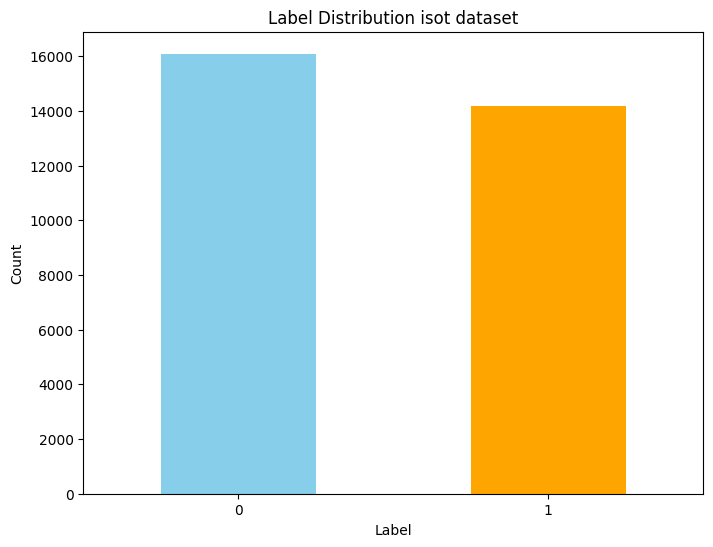

In [4]:
# plots
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('/content/drive/My Drive/fac/master/bigData/big_data_project')

from data_pipeline import get_dataloaders, text_preprocess, isot_clean

checkpoint_path = '../../drive/My Drive/fac/master/bigData/trained_model/'

(train_loader, val_loader, test_loader), (tokenizer, vocab) = get_dataloaders(dataset_id="isot", model="bert")

train_dataset = train_loader.dataset
data = [sample for sample in train_dataset]

df = pd.DataFrame(data)

inputs = df[0].tolist()
labels = df[1].tolist()
df = df.rename(columns={0: 'input_data', 1: 'label', 2: 'id'})

# Plotting label distribution
plt.figure(figsize=(8, 6))
df['label'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Label Distribution isot dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [ ]:
!pwd

/content/bigData/big_data_project
